In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=3).mean()
    data['SMA100'] = data['Close'].rolling(window=5).mean()
    vol_window = 3
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    pred_count = 0
    red_x,red_y, black_y, blue_x, blue_y, green_y = [],[],[],[],[],[]
    for idx in range(0,s.shape[0], pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 3))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 3))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label
        if idx< cut_off:
            red_x +=[idx]
            red_y+=[future_transform]
            black_y+=[future_true_transform]
        else:
            blue_x +=[idx]
            blue_y+=[future_transform]
            green_y+=[future_true_transform]

        # # Plot the predictions
        # plt.scatter(idx, future_transform, 
        # # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        #     color="red" if idx < cut_off else "blue")


        # # plt.plot(np.arange(idx, idx + pred_len), future_transform, 
        # #         # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        # #          color="red" if idx < cut_off else "blue")

        # # Plot the true values
        # plt.scatter(idx, future_true_transform, 
        #          #label="Train True" if idx < cut_off else "Test True", 
        #          color="black" if idx < cut_off else "green")

        
        if idx >= cut_off:
            pred_count+=1
    plt.plot(red_x, red_y, color = "red")
    plt.plot(red_x, black_y, color = "black")
    plt.plot(blue_x, blue_y, color = "blue")
    plt.plot(blue_x, green_y, color = "green")
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    # for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        # plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    # for i, rmse in zip(section_start_idx, rmse_values):
    #     plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    # plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    # print(rmse_values)
    # plt.grid(True)

    if m == "NN w/ 7 features":
        dir = f"{seq_len}-{pred_len}/nn_7"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "NN w/ 7 features"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2024-11-03", end_date="2024-12-02")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        # tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close', 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # Step 5: Perform Hankel Matrix Decomposition
        window_size = 2  # Size of the sliding window to form the Hankel matrix
        hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # Step 6: Perform SVD on the Hankel matrix
        U, Sigma, Vt = hankel_svd(hankel_matrix)

        # You can choose the first few singular values and modes to add as features
        num_modes = 2  # Number of modes to add as features
        dmd_modes = U[:, :num_modes]  # Select the modes
        dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # Trim the processed_data to match the number of rows in dmd_modes
        processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # Combine the Hankel decomposition modes with the processed data
        data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 1  # 6 months of data
        pred_len = 1  # Predict the next 20 days
        sequences = create_sequences(data_combined, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.8 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, data_combined, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

[*********************100%***********************]  1 of 1 completed
/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(13, 2, 7)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3556
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0807
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1528
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1599
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - loss: 0.0962
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.0578
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0604
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0792
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0883
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0810
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0651
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0516
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0476
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0528
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0602
Epo

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5914
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1474
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1132
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2102
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1784
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1075
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0725
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0794
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1025
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1150
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1099
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0936
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0762
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0655
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0646
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - loss: 0.2435
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0774
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1219
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0942
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0491
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0390
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0554
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0635
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0536
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0393
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0339
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0384
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0417
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0373
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0298
Epoch 16/100
1/1 ━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step - loss: 0.2043
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0792
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1263
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1053
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0665
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0571
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0664
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0694
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0590
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0442
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0353
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0354
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0380
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0341
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0244
Epoch 16/100
1/1 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - loss: 0.1974
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0742
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0953
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0879
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0531
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0370
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0434
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0509
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0461
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0349
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0281
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0297
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0329
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0305
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0244
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - loss: 0.3935
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1350
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0892
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1485
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1464
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1056
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0757
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0717
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0831
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0925
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0907
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0802
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0673
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0579
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0550
Epoch 16/100
1/1 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - loss: 0.3510
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1083
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0510
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0960
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1021
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0672
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0357
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0276
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0381
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0503
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0517
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0429
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0315
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0241
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0239
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 0.3453
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0891
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1307
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1052
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0624
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0416
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0452
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0570
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0604
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0525
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0396
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0302
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0290
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0341
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - loss: 0.1455
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1095
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0976
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0591
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0560
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0616
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0508
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0353
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0313
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0345
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0285
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0173
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0141
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0166
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0131
Epoch 16/100
1/1 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(13, 2, 7)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - loss: 0.5681
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1164
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0859
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1994
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1582
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0816
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0478
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0581
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0833
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0969
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0926
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0764
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0582
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0457
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0427
Epoch 16/100
1/1 ━━━━━━━━━━━━

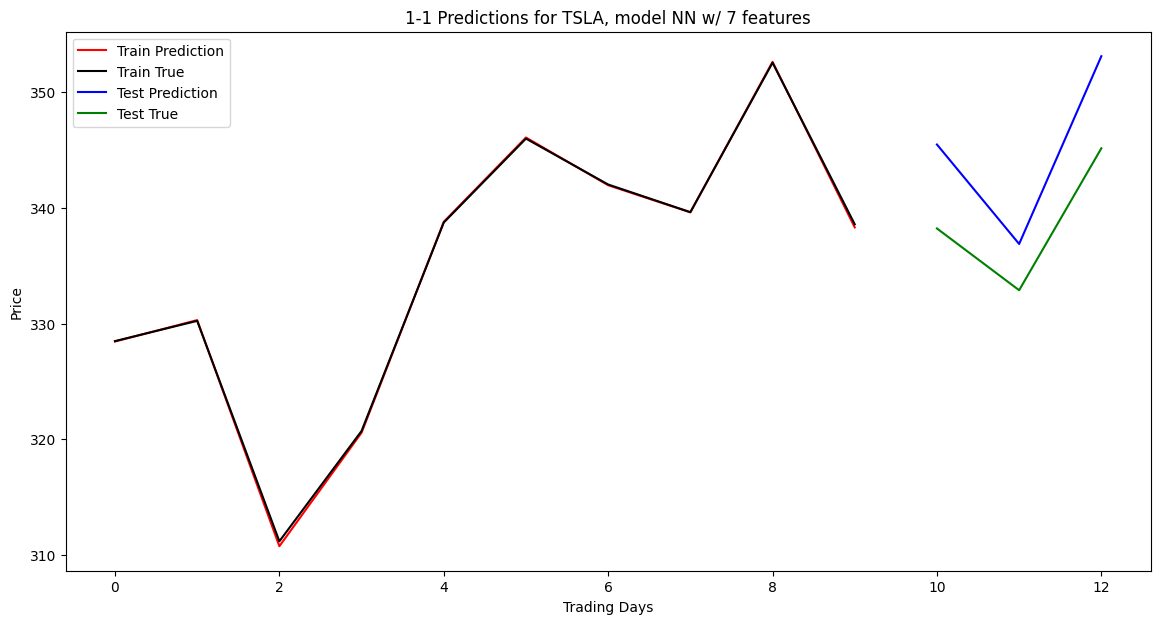

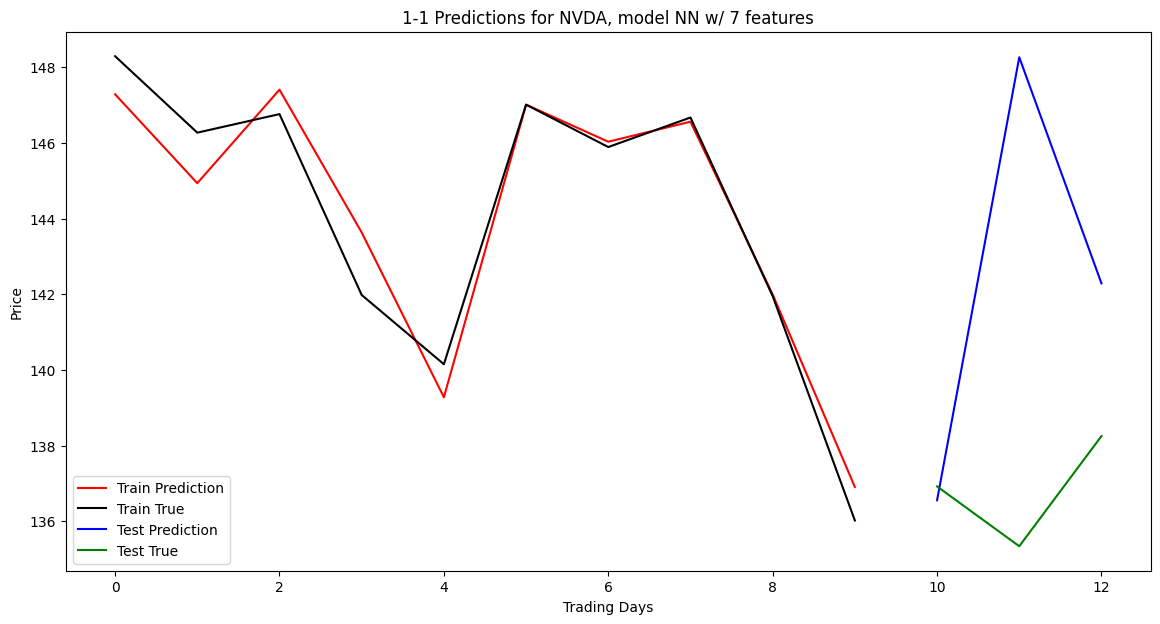

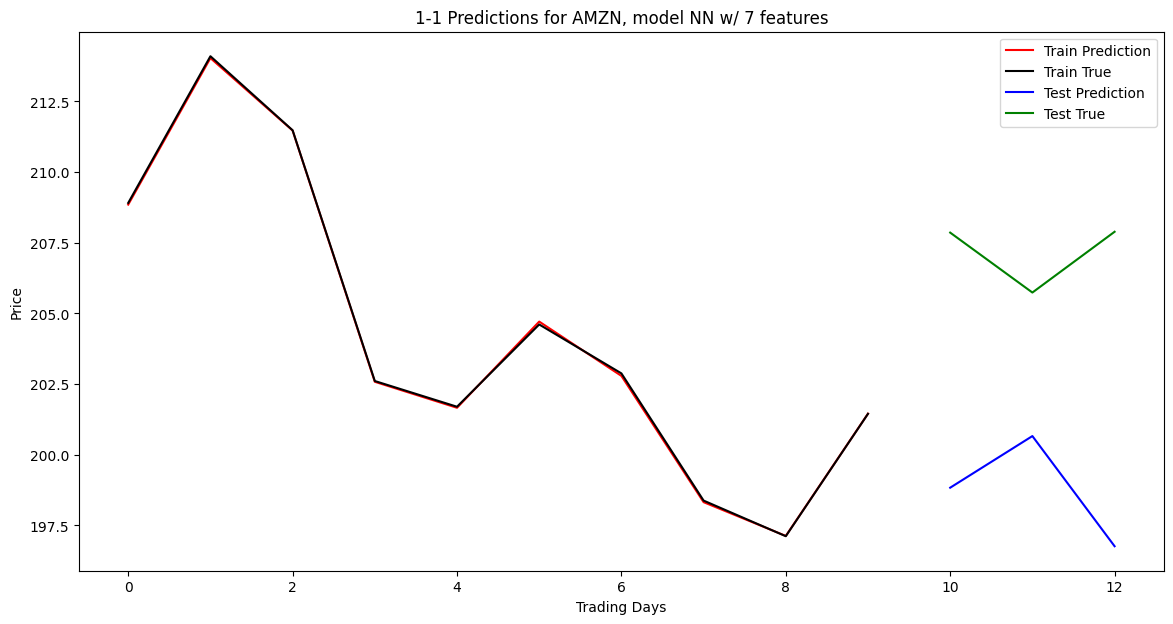

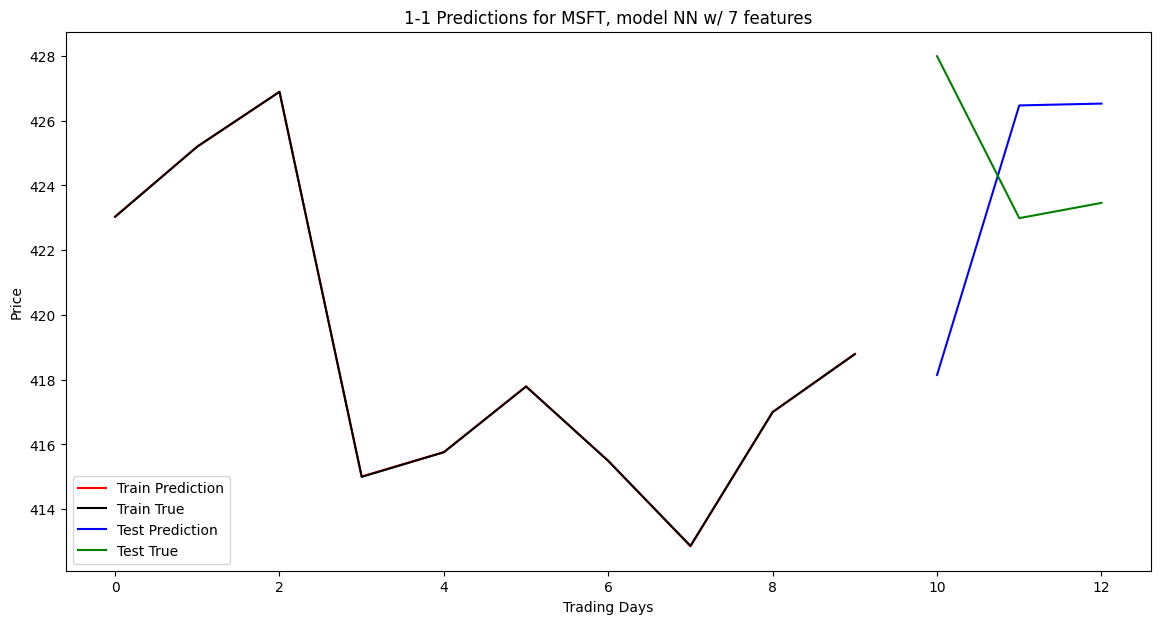

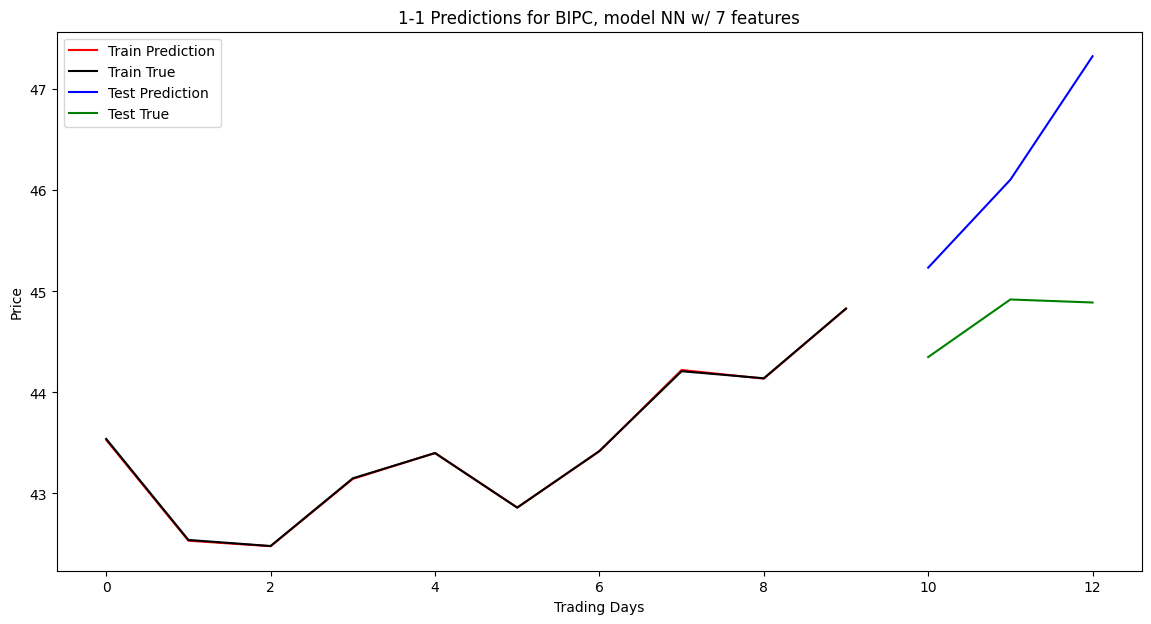

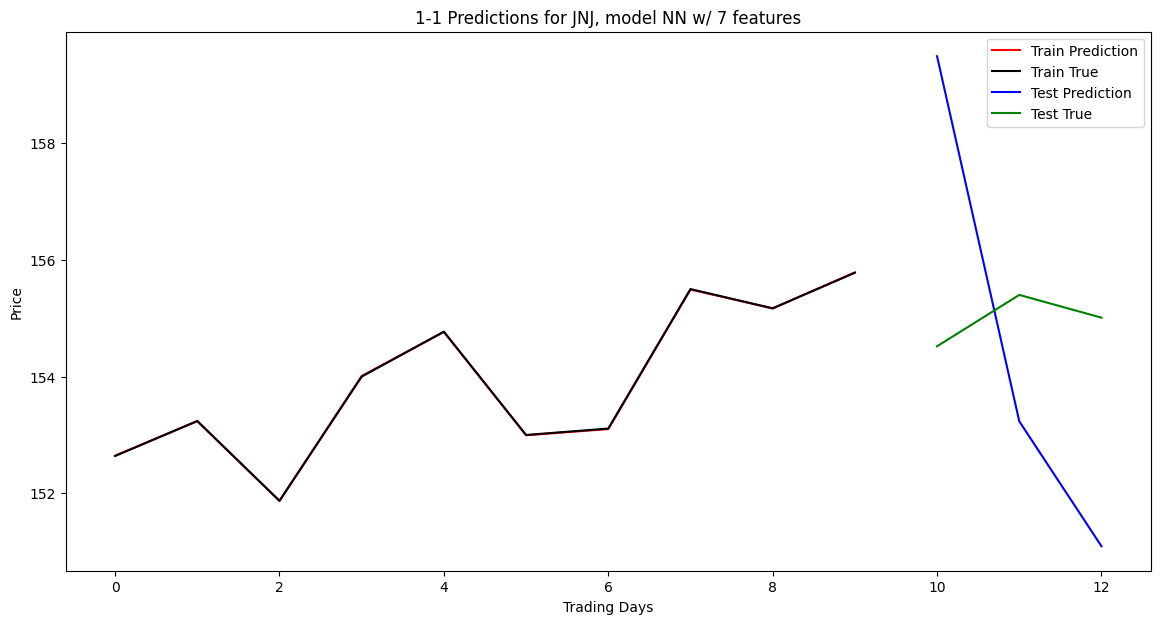

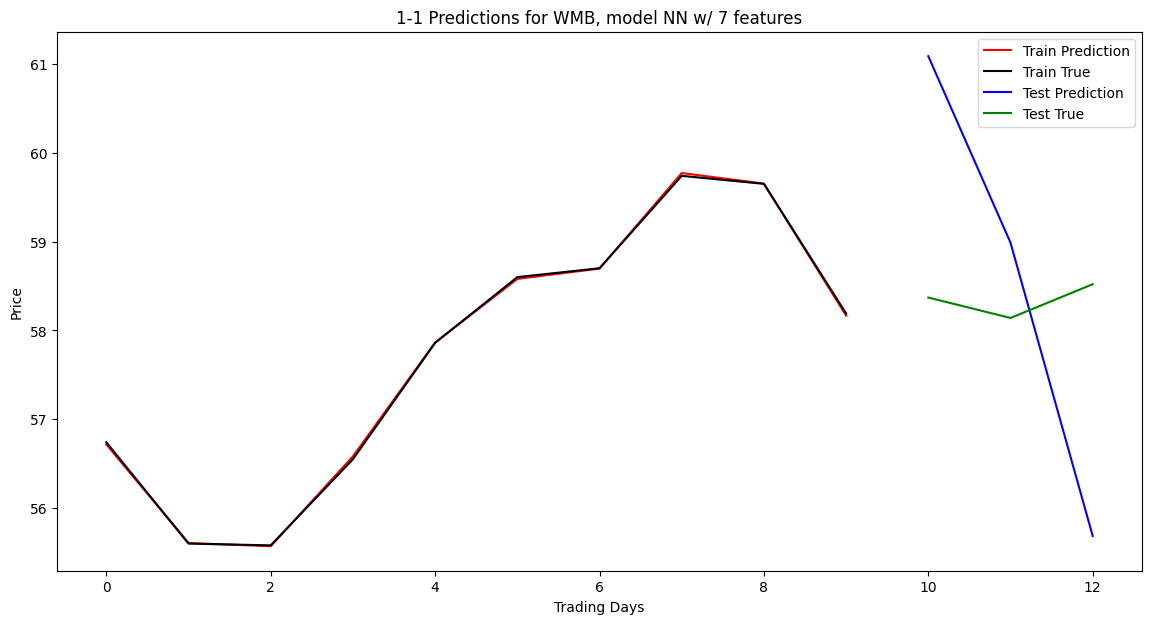

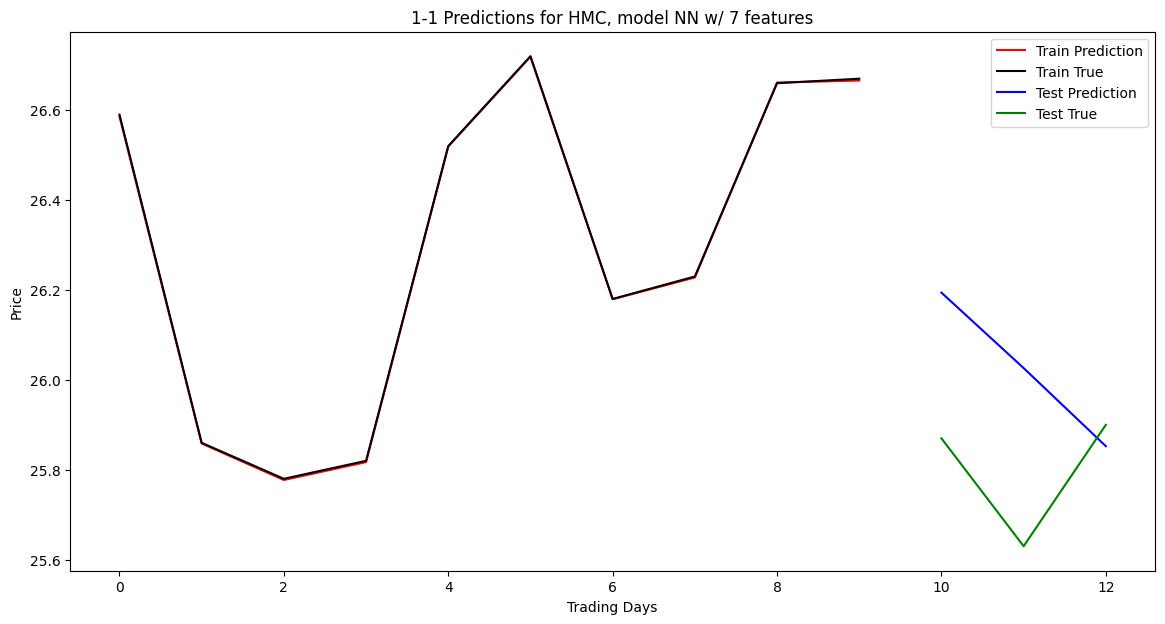

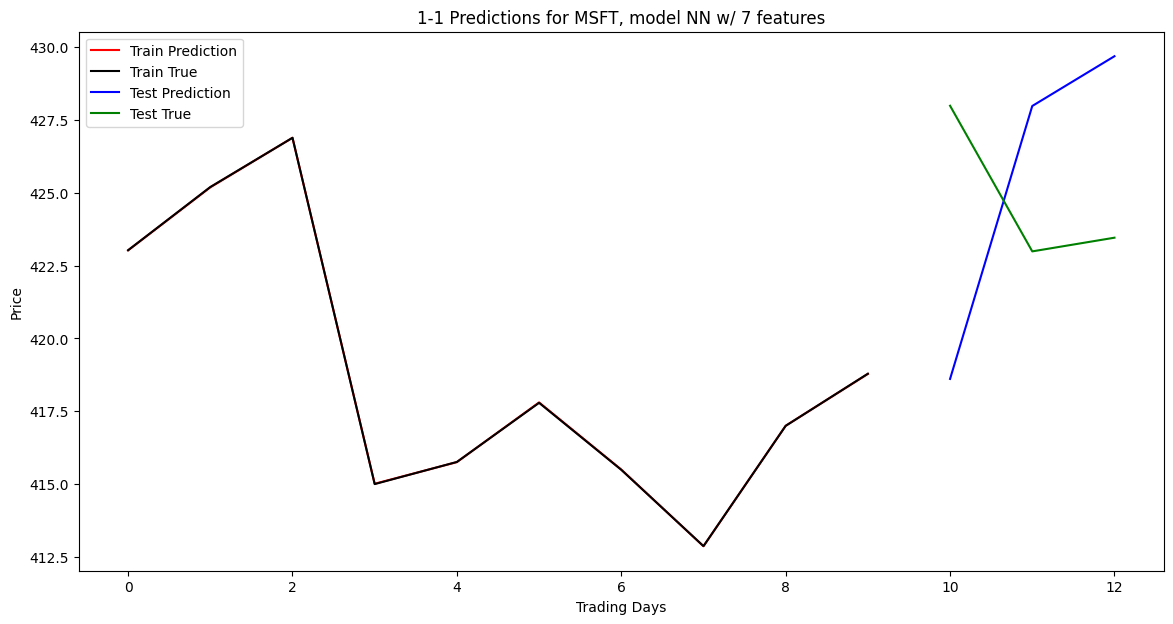

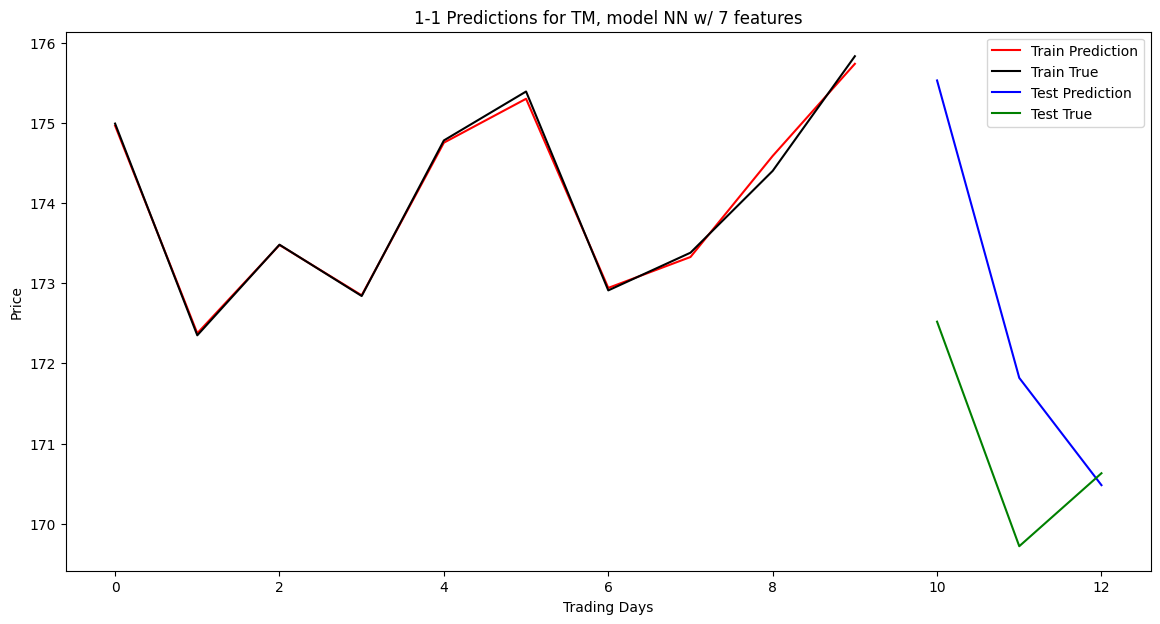

In [6]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [7]:
mse

2.584389339350765